In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import geopandas as gpd
import scanpy as sc
from PIL import Image # Converting image
import os # for parquet file
from pathlib import Path

# from tifffile import imread, imwrite
# from csbdeep.utils import normalize
# from stardist.models import StarDist2D
from shapely.geometry import Polygon, Point
from scipy import sparse
from matplotlib.colors import ListedColormap
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path as MplPath 
%matplotlib widget


TODO:

1. Create a scatter plot of UMI and gene counts, plot the averages per sample
    - And a scatter for each section
3. is there a way to combine the geo_file and
4. Sanity check, plot cells in each section and double check the that the morphology matches
5. Rerun and rebin F07836 - I need to make sure that the offset starts off after the largest number.
6. Why does the geo file have more id's than the adata?

# Selecting sections

In [120]:
SEGMENTATION_PATH = Path("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/"
                         "dietary_droject/data/cell_segmentation")

sample_id = "F07838"

adata_path = SEGMENTATION_PATH / sample_id / f"{sample_id}_grouped_filtered_adata_rebinned.h5ad"
gdf_file = SEGMENTATION_PATH / sample_id / f"{sample_id}_gdf_rebinned.gpkg"

# Load adata
ST_sample = sc.read_h5ad(adata_path)
# load your polygons
geo_file = gpd.read_file(gdf_file)

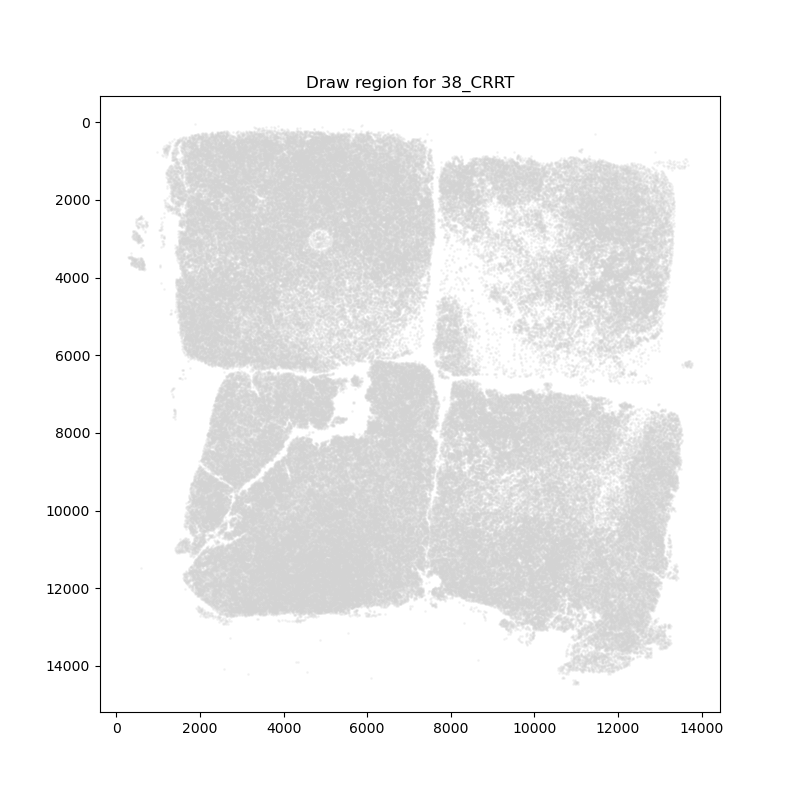

In [122]:
# Define the labels you want to draw
tissue_labels = ["38_CRRT", "34_LGIRT", "32_RT", "36_CRRT"]


# Precompute centroids
geo_file['cx'] = geo_file.geometry.centroid.x
geo_file['cy'] = geo_file.geometry.centroid.y

# 4. Set up stateful counters
counter = [0]      # will go 0 → 1 → 2 → 3
overlay = []       # to store the scatter handles

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(geo_file['cx'], geo_file['cy'], s=1, alpha=0.2, color='lightgray')
ax.invert_yaxis()
ax.set_title(f"Draw region for {tissue_labels[0]}")

def onselect(verts):
    i     = counter[0]
    label = tissue_labels[i]

    # build a Path
    path = MplPath(verts)
    pts  = geo_file[['cx','cy']].values
    mask = path.contains_points(pts)

    # assign region label
    geo_file.loc[mask, 'mouse'] = label
    print(f"→ {mask.sum()} cells labeled “{label}”")

    # overlay those points in a new color
    colors = ["#66c2a5", "#fc8d62", "#8da0cb", "#984ea3"]
    h = ax.scatter(
        geo_file.loc[mask,'cx'],
        geo_file.loc[mask,'cy'],
        s=4, color=colors[i], alpha=0.8,
        label=label
    )
    overlay.append(h)

    # advance counter or finish
    counter[0] += 1
    if counter[0] < len(tissue_labels):
        ax.set_title(f"Now draw region for {tissue_labels[counter[0]]}")
    else:
        ax.set_title("Done! Closing selector…")
        lasso.disconnect_events()
        # ax.invert_yaxis()
        ax.legend(handles=overlay, loc='best')
        fig.canvas.draw_idle()
        plt.show()

    ax.legend(handles=overlay, loc='best')
    fig.canvas.draw_idle()

lasso = LassoSelector(ax, onselect)
plt.show()

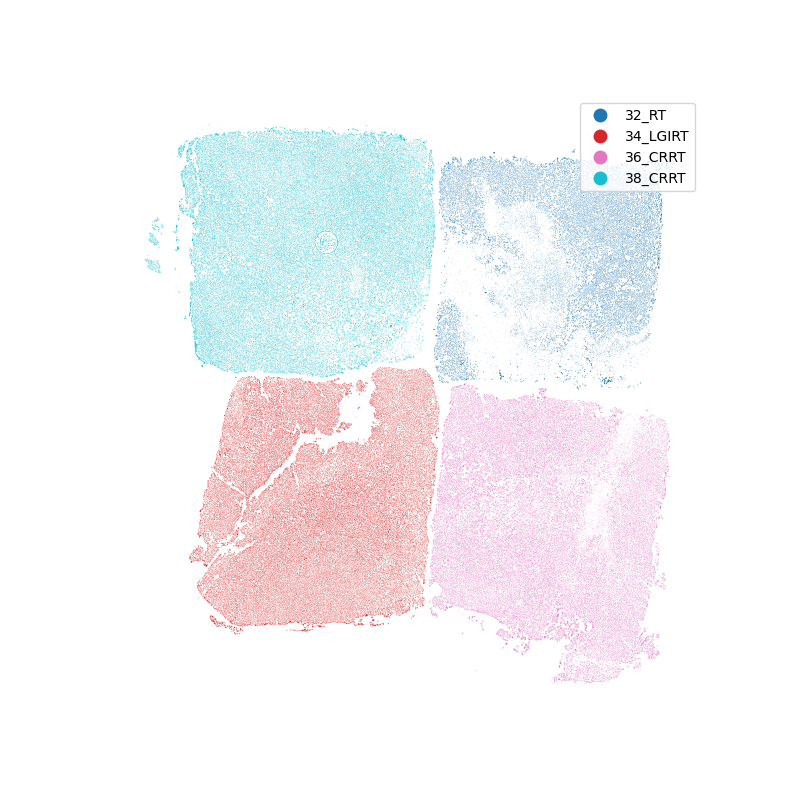

Figure saved to: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/F07838/figures/F07838_tissue_selection.png


In [123]:

# Create figure and axis
fig, ax = plt.subplots(figsize=(8,8))

# Plot
geo_file.plot(
    column='mouse',
    categorical=True,
    legend=True,
    markersize=5,
    cmap=None,            # or you can set cmap="tab10" or similar
    ax=ax
)

# Adjustments
ax.invert_yaxis()
ax.axis('off')

# Create output folder if needed
fig_base = SEGMENTATION_PATH / sample_id / "figures"
fig_base.mkdir(parents=True, exist_ok=True)

# Save figure
selected_fig = fig_base / f"{sample_id}_tissue_selection.png"
fig.savefig(selected_fig, dpi=600, bbox_inches='tight')

# Show figure below the cell
plt.show()

print(f"Figure saved to: {selected_fig}")

# Putting it together

In [124]:
# Derive condition from your lasso labels
geo_file['condition'] = geo_file['mouse'].str.split('_', n=1).str[1]

# Drop any nuclei you never labeled
geo_file = geo_file.dropna(subset=['mouse']).copy()

# Add sample‐level info
geo_file['sample_id'] = sample_id

In [125]:
# Make your mini metadata table keyed by nucleus “id”
meta = (
    geo_file
    .set_index('id')[['mouse','sample_id','condition','cx','cy']]
)

# Join just those five columns into your AnnData.obs
ST_sample.obs = ST_sample.obs.join(
    meta,    # has exactly mouse, sample_id, condition, cx, cy
    on='id'
)

# Drop any AnnData spots that still lack a label
ST_sample = ST_sample[ST_sample.obs['condition'].notna(), :].copy()

# Save clean AnnData
outpath_adata_loc = SEGMENTATION_PATH / sample_id / "labeled_files"
outpath_adata_loc.mkdir(parents=True, exist_ok=True)

outpath_adata = outpath_adata_loc / f"{sample_id}_labeled_adata.h5ad"
ST_sample.write(outpath_adata)
print("Wrote:", outpath_adata_loc)


# ───────────────────────────────────────────────────────────────────────────────
out_geo = outpath_adata_loc / f"{sample_id}_nuclei_geometry.gpkg"
geo_file.to_file(out_geo, driver="GPKG")
print("Wrote full geo_file (all columns) to:", out_geo)

Wrote: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/F07838/labeled_files


/home/jon/anaconda3/envs/spatial_analysis/lib/python3.10/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Wrote full geo_file (all columns) to: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/F07838/labeled_files/F07838_nuclei_geometry.gpkg


In [114]:
# #COMbine later

# import anndata as ad

# samples = ["F07833","F07834","F07835","F07836"]
# adatas = [sc.read_h5ad(f"{s}_annotated_adata.h5ad") for s in samples]

# # concat along observations, keep the geometry in obsm
# combined = ad.concat(adatas, join="outer", label="sample_id", keys=samples)
# combined.write("combined_TMA_all.h5ad")

# Sanity check saves

In [126]:
# (a) load your cleaned AnnData and geo package
adata = sc.read_h5ad(outpath_adata)
geo   = gpd.read_file(out_geo)

# get the list of mouses present in both
common_samples = set(adata.obs['mouse'].unique()) & set(geo['mouse'].unique())

In [127]:
common_samples

{'32_RT', '34_LGIRT', '36_CRRT', '38_CRRT'}

In [128]:
for sp in sorted(common_samples):
    # IDs in AnnData for this sample
    ad_ids  = set(adata.obs_names[adata.obs['mouse'] == sp])
    # IDs in geo_file for this sample
    geo_ids = set(geo.loc[geo['mouse'] == sp, 'id'])
    
    # intersection count
    n_match   = len(ad_ids & geo_ids)
    n_adata   = len(ad_ids)
    n_missing = n_adata - n_match
    
    print(f"Sample {sp}:")
    print(f"  AnnData nuclei: {n_adata}")
    print(f"  Matches in geo_file: {n_match}")
    if n_missing == 0:
        print("  ✅ All IDs in AnnData were found in geo_file!")
    else:
        print(f"  ⚠️ {n_missing} AnnData IDs were NOT in geo_file.")
    print()

Sample 32_RT:
  AnnData nuclei: 17903
  Matches in geo_file: 17903
  ✅ All IDs in AnnData were found in geo_file!

Sample 34_LGIRT:
  AnnData nuclei: 47097
  Matches in geo_file: 47097
  ✅ All IDs in AnnData were found in geo_file!

Sample 36_CRRT:
  AnnData nuclei: 32995
  Matches in geo_file: 32995
  ✅ All IDs in AnnData were found in geo_file!

Sample 38_CRRT:
  AnnData nuclei: 32656
  Matches in geo_file: 32656
  ✅ All IDs in AnnData were found in geo_file!



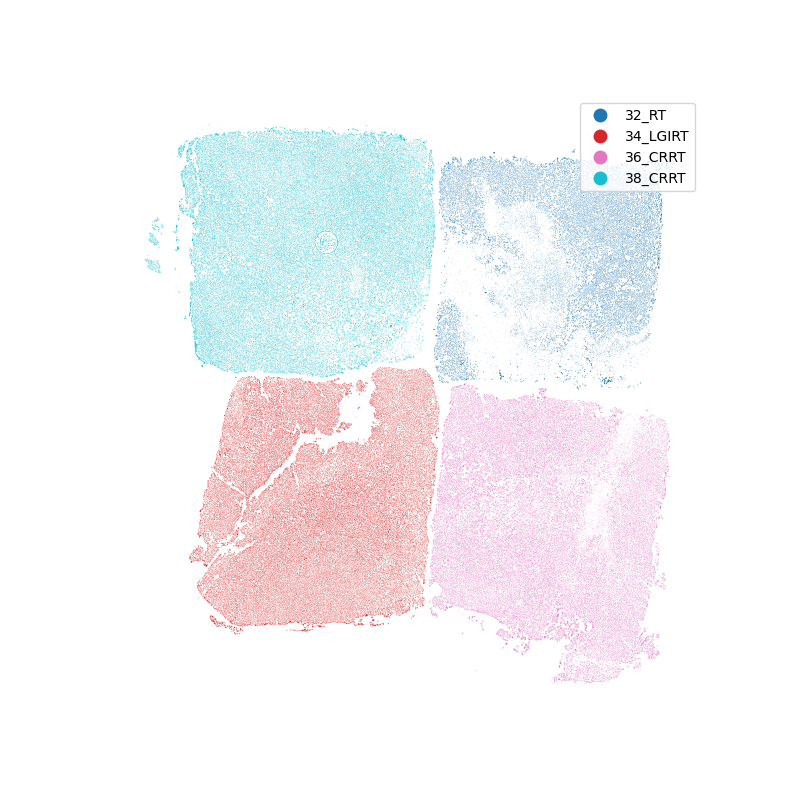

In [129]:
# ─── 2. Re-plot the tissue selections ───────────────────────────────────────────
# assume only one sample per file; pull it out
sample_id = geo['sample_id'].unique()[0]

fig, ax = plt.subplots(figsize=(8,8))
geo.plot(
    column='mouse',
    categorical=True,
    legend=True,
    markersize=5,
    cmap=None,      # or choose your own cmap like "tab10"
    ax=ax
)
ax.invert_yaxis()
ax.axis('off')
plt.show()


In [130]:
# INTENTIONALLY EMPTY
print("STOP!")

STOP!


# Visualizing ST_sample

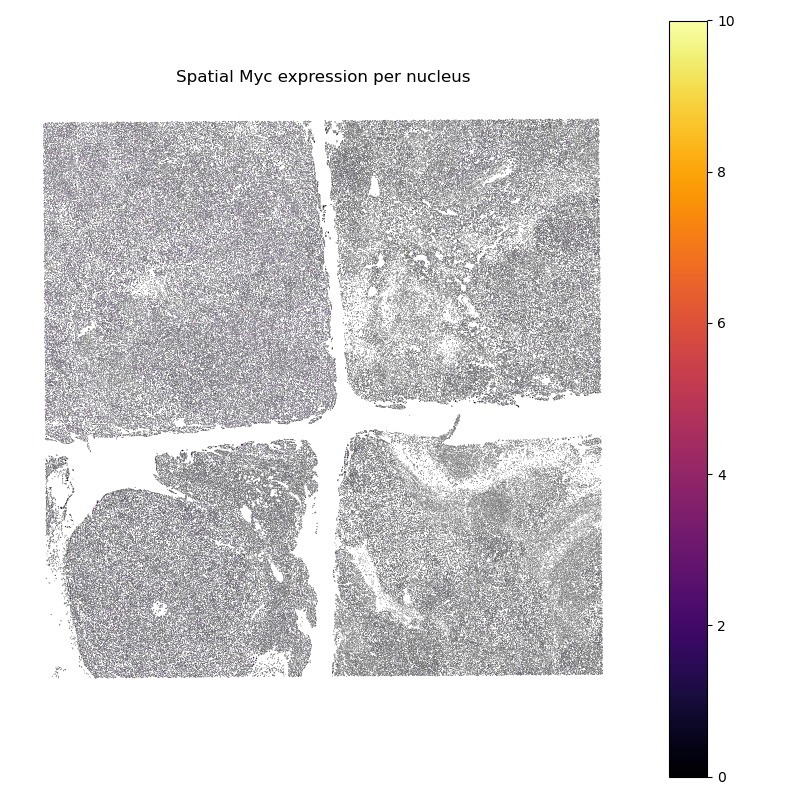

In [29]:
# 1) pull gene X into obs (flatten sparse → array)
gene = "Ar"
# if X is sparse, use .toarray() or .A1; adjust if it's dense
ST_sample.obs[gene] = ST_sample[:, gene].X.toarray().ravel()

# 2) build a GeoDataFrame keyed by id
gdf = gpd.GeoDataFrame(
    ST_sample.obs.copy(),                # all your obs columns
    geometry=list(ST_sample.obsm['geometry']),  # list of shapely Polygons
)

# 3) plot it
fig, ax = plt.subplots(figsize=(8,8))
gdf.plot(
    column=gene,        # color by Myc expression
    cmap="inferno",     # or any matplotlib colormap
    linewidth=0.1,
    edgecolor="gray",
    legend=True,
    ax=ax
)
ax.set_title(f"Spatial Myc expression per nucleus")
ax.invert_yaxis()      # if you want image‐style coords
ax.axis("off")
plt.tight_layout()
plt.show()

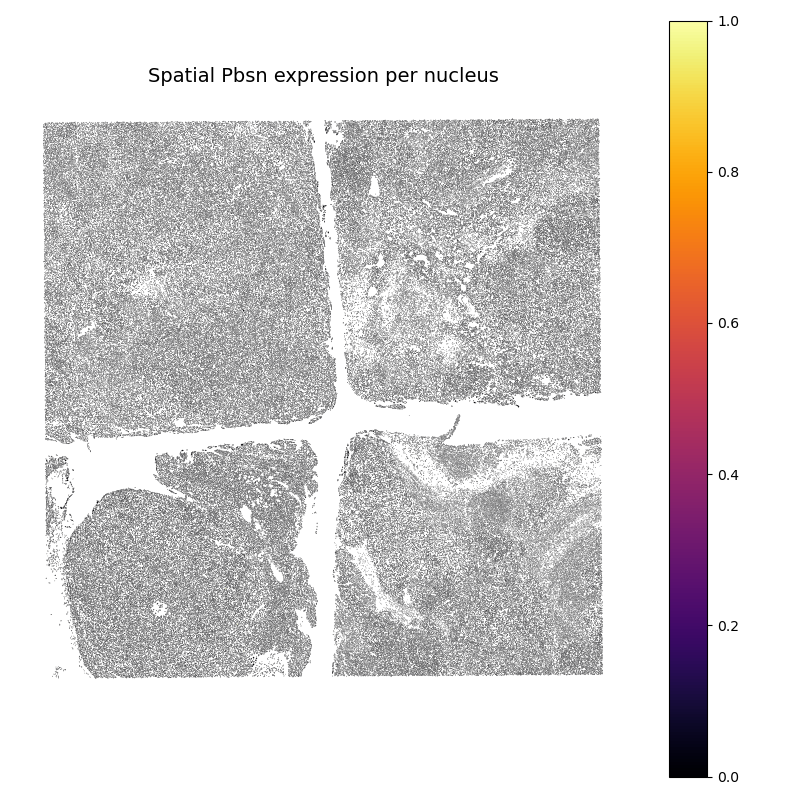

Figure saved at: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/F07833/figures/F07833_Pbsn_expression.png


In [31]:
# 1) pull gene X into obs
gene = "Pbsn"
# if X is sparse
ST_sample.obs[gene] = ST_sample[:, gene].X.toarray().ravel()

# 2) build GeoDataFrame
gdf = gpd.GeoDataFrame(
    ST_sample.obs.copy(),
    geometry=list(ST_sample.obsm['geometry']),
)

# 3) make plot
fig, ax = plt.subplots(figsize=(8,8))
gdf.plot(
    column=gene,
    cmap="inferno",
    linewidth=0.1,
    edgecolor="gray",
    legend=True,
    ax=ax
)
ax.set_title(f"Spatial {gene} expression per nucleus", fontsize=14)
ax.invert_yaxis()
ax.axis('off')
plt.tight_layout()

# 4) save the figure
fig_base = SEGMENTATION_PATH / sample_id / "figures"
fig_base.mkdir(parents=True, exist_ok=True)  # make sure folder exists
selected_fig = fig_base / f"{sample_id}_{gene}_expression.png"
fig.savefig(selected_fig, dpi=600, bbox_inches='tight')

# 5) now show
plt.show()

print(f"Figure saved at: {selected_fig}")


In [18]:
# ═══ after you finish all your lasso selections ═══

# 1) annotate sample and derive condition
geo_file['sample_id'] = sample_id

geo_file['condition'] = geo_file['mouse'].str.split('_', n=1).str[1]  # whatever comes after the first “_”

In [19]:
geo_file['condition'].unique()

array(['RT', 'LFRT', 'CRRT', 'KDRT', nan], dtype=object)

In [ ]:
# 2) build a small metadata table, keyed by nucleus “id”
meta = (
    geo_file
    .set_index('id')[['mouse','sample_id','condition','cx','cy','geometry']]
)

# 3) join those columns into your AnnData.obs
#    (assumes `ST_sample.obs` also has an “id” column matching meta.index)
ST_sample.obs = ST_sample.obs.join(
    meta[['mouse','sample_id','condition','cx','cy']],
    on='id'
)

# 4) store the actual Shapely geometries in .obsm so they survive concatenation
ST_sample.obsm['geometry'] = meta['geometry']

# 5) write out your annotated AnnData
outpath = SEGMENTATION_PATH / sample_id / f"{sample_id}_annotated_adata.h5ad"
ST_sample.write(outpath)
print("Wrote:", outpath)